In [ ]:
!pip install spotipy
import calendar
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import json
import numpy as np
from datetime import timedelta
#from spotipy import history
from time import sleep
import ast
from typing import List
from os import listdir
import spotipy.util as util


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import plotly.io as pio
pio.renderers.default = "colab"

import plotly.graph_objects as go
print("Listo!")

     |████████████████████████████████| 138 kB 11.7 MB/s 
     |████████████████████████████████| 62 kB 550 kB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Listo!


In [ ]:
def read_history(): #convertir archivos json a un dataframe de pandas
    history = []
    for file in sorted(glob("StreamingHistory*.json")): #leer todos los archivos de stream
        with open(file) as readable:
            history.extend(json.load(readable))
    history = pd.DataFrame(history)
    history["endTime"] = pd.to_datetime(history["endTime"])
    return history


def artistas_populares_reproducciones(history): 
  history['minutes_played'] = history.msPlayed.divide(60000)
  history.drop('msPlayed', axis=1, inplace=True)

  most_played_artists_by_count = history.groupby(by='artistName')['trackName'].count().sort_values(ascending=False)[:15]

#print('Artistas más populares por el número de veces que sus canciones fueron reproducidas: \n\n{}'.format(most_played_artists_by_count))

# Visualizar artistas mas populares

  colors = ['RGB(103, 0, 31)','RGB(178, 24, 43)','RGB(214, 96, 77)','RGB(244, 165, 130)','RGB(253, 219, 199)',
          'RGB(247, 247, 247)','RGB(209, 229, 240)','RGB(146, 197, 222)','RGB(67, 147, 195)','RGB(33, 102, 172)',
          'RGB(5, 48, 97)']


  layout = go.Layout(
    title='Artistas más populares por el no. de veces que sus canciones fueron reproducidas',
    yaxis= dict(
        title="No. de veces reproducidas",
        gridcolor='rgb(255, 255, 255)',
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
        titlefont=dict(size=15)),
    xaxis=dict(title="Artist Name"))


  fig = go.Figure(data=[go.Bar(x=most_played_artists_by_count.index,
                             y=most_played_artists_by_count,
                             textposition='auto',
                             opacity=1,
                             marker_color=colors)])

  fig.update_layout(
    title="Artistas más populares por el no. de veces que sus canciones fueron reproducidas",
    xaxis_title="Artista",
    yaxis_title="No. reproducciones")

  fig.show()


def artistas_por_tiempo(history):
  # Artistas mas populares por tiempo de stream
  history['minutes_played'] = history.msPlayed.divide(60000)
  history.drop('msPlayed', axis=1, inplace=True)
  
  amount_of_time = history.groupby(by='artistName')['minutes_played'].sum().sort_values(ascending=False)[:15]

  #amount_of_time


  colors = ['RGB(103, 0, 31)','RGB(178, 24, 43)','RGB(214, 96, 77)','RGB(244, 165, 130)','RGB(253, 219, 199)',
            'RGB(247, 247, 247)','RGB(209, 229, 240)','RGB(146, 197, 222)','RGB(67, 147, 195)','RGB(33, 102, 172)',
            'RGB(5, 48, 97)']

  layout = go.Layout(
      title='Popularity of artists by amount of time spent listening to their song',
      yaxis= dict(
          title='Amount of time (in minutes)',
          gridcolor='rgb(255, 255, 255)',
          zerolinewidth=1,
          ticklen=5,
          gridwidth=2,
          titlefont=dict(size=15)),
      xaxis= dict(
          title = 'Artist Name'))


  fig = go.Figure(data=[go.Bar(x=amount_of_time.index,
                              y=amount_of_time,
                              opacity=1,
                              marker_color=colors)])

  fig.update_layout(
      title="Artistas más populares por los minutos que sus canciones fueron reproducidas",
      xaxis_title="Artista",
      yaxis_title="No. min reproducidos")

  fig.show()


def linea_tiempo(history):
  history['minutes_played'] = history.msPlayed.divide(60000)
  history.drop('msPlayed', axis=1, inplace=True)

  history['day'] = [d.date() for d in history['endTime']]
  history['time'] = [d.time() for d in history['endTime']]
  history.drop('endTime', axis=1, inplace=True)

  day = history.groupby(by=['day'], as_index=False).sum()

  fig = px.line(day, x="day", y="minutes_played",
                labels={
                      "day": "Mes",
                      "minutes_played": "Minutos"},
                color_discrete_sequence=px.colors.sequential.RdBu, title="Linea del tiempo de mi stream de música")

  fig.show()


def canciones_dia_mes(streaming_history):

  streaming_history["date"] = streaming_history["endTime"].dt.floor('d')

  by_date = streaming_history.groupby("date")[["trackName"]].count()
  by_date = by_date.sort_index()

  by_date["weekday"] = by_date.index.weekday
  by_date["week"] = by_date.index.week

  week = 0
  prev_week = by_date.iloc[0]["week"]
  continuous_week = np.zeros(len(by_date)).astype(int)
  sunday_dates = []
  for i, (_, row) in enumerate(by_date.iterrows()):
      if row["week"] != prev_week:
          week += 1
          prev_week = row["week"]
      continuous_week[i] = week
  by_date["continuous_week"] = continuous_week

  songs = np.full((7, continuous_week.max()+1), np.nan)

  for index, row in by_date.iterrows():
      songs[row["weekday"]][row["continuous_week"]] = row["trackName"]

  min_date = streaming_history["endTime"].min()
  first_monday = min_date - timedelta(min_date.weekday())
  mons = [first_monday + timedelta(weeks=wk) for wk in range(continuous_week.max())]
  x_labels = [calendar.month_abbr[mons[0].month]]
  x_labels.extend([
      calendar.month_abbr[mons[i].month] if mons[i-1].month != mons[i].month else "" 
      for i in range(1, len(mons))])

  y_labels = ["Lun", "", "Mier", "", "Vier", "", "Dom"]

  fig = plt.figure(figsize=(20,5))
  ax = plt.subplot()

  ax.set_title("Mi año en spotify", fontsize=20,pad=40)
  ax.xaxis.tick_top()
  ax.tick_params(axis='both', which='both',length=0)
  ax.set_facecolor("#ebedf0") 
  fig.patch.set_facecolor('white')

  sns.heatmap(songs, linewidths=2, linecolor='white', square=True,
              mask=np.isnan(songs), cmap="rocket_r",
            cbar=True, ax=ax)

  ax.set_yticklabels(y_labels, rotation=0)
  ax.set_xticklabels(x_labels, ha="left")



def canciones_dias(date):


  date['minutes_played'] = date.msPlayed.divide(60000)
  date.drop('msPlayed', axis=1, inplace=True)

  date['day'] = pd.DatetimeIndex(date['endTime']).day_name()

  date = date.groupby(by=['day'], as_index=False).sum()
  fig = px.pie(date, names="day", values="minutes_played", color_discrete_sequence=px.colors.sequential.RdBu)

  fig.show()


def canciones_artistas_unicos(df):

  artist=df

  artist['minutes_played'] = artist.msPlayed.divide(60000)
  artist.drop('msPlayed', axis=1, inplace=True)
  artist.drop('endTime', axis=1, inplace=True)

  artist_1 = artist.drop_duplicates(subset = ["trackName"])
  artist_1.drop('minutes_played', axis=1, inplace=True)

  artist_1 = artist_1.groupby(['artistName'], as_index = False).count()

  artist_1 = artist_1.rename(columns={"trackName": "unique_songs"})
  time = artist.groupby(['artistName'], as_index=False).sum()

  top_artist = pd.merge(artist_1, time, on='artistName')
  top_artist = top_artist.sort_values(by='unique_songs', ascending=False).tail(20)
  fig = px.scatter(top_artist, x="artistName", y="minutes_played",
                  title="Tiempo total escuchando a cada artista (canciones únicas)",
                  labels={
                      "artistName": "Nombre del artista",
                      "minutes_played": "Minutos escuchados"},
                  size="unique_songs",
                  color_discrete_sequence=px.colors.sequential.RdBu)
  fig.show()



def canciones_mas_escuchadas(song):

  song['minutes_played'] = song.msPlayed.divide(60000)
  song.drop('msPlayed', axis=1, inplace=True)
  song = song.groupby(['trackName'], as_index=False).sum()
  song = song.sort_values(by='minutes_played', ascending=False)

  song_artist = read_history()

  song_artist = song_artist.sort_values(by='trackName', ascending=False)
  song_artist.drop('endTime', axis=1, inplace=True)
  song_artist.drop('msPlayed', axis=1, inplace=True)
  song_artist = song_artist.drop_duplicates(subset = ["trackName"])


  song = pd.merge(song_artist, song, on='trackName')
  song = song.sort_values(by='minutes_played', ascending=False)

  song = song.sort_values(by='minutes_played', ascending=False).head(16)
  song.reset_index(inplace = True, drop = True) 

  fig = px.bar(song, x="trackName", y="minutes_played",
              title = 'Canciones más escuchadas',
              labels={
                      "artistName": "Artista",
                      "minutes_played": "Minutos escuchados",
                      "trackName": "Canción"},
              color = "artistName", color_discrete_sequence=px.colors.sequential.RdBu)
  fig.show()


In [ ]:
history = read_history()
history

,endTime,artistName,trackName,msPlayed
0,2019-12-08 20:40:00,Coldplay,See You Soon - Live in Sydney,176884
1,2019-12-09 16:45:00,Paul Zinnard,A Good Thing That You Know,210467
2,2019-12-09 16:49:00,Los Claxons,Cautiverio,248083
3,2019-12-09 16:54:00,Standstill,Hay Que Parar - III. El Corazón De B. Despierta,303532
4,2019-12-09 16:55:00,Love of Lesbian,Tercero segunda,83666
...,...,...,...,...
32246,2020-12-09 22:48:00,The Rolling Stones,You Can't Always Get What You Want,870
32247,2020-12-09 22:48:00,Daniel Quién,A Estas Horas Del Amor,4716
32248,2020-12-09 22:48:00,Lewin,Emotravel,943
32249,2020-12-09 22:48:00,Daniel Quién,Otros Colores,351813


In [ ]:
artistas_populares_reproducciones(read_history())

In [ ]:
artistas_por_tiempo(read_history())

In [ ]:
linea_tiempo(read_history())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



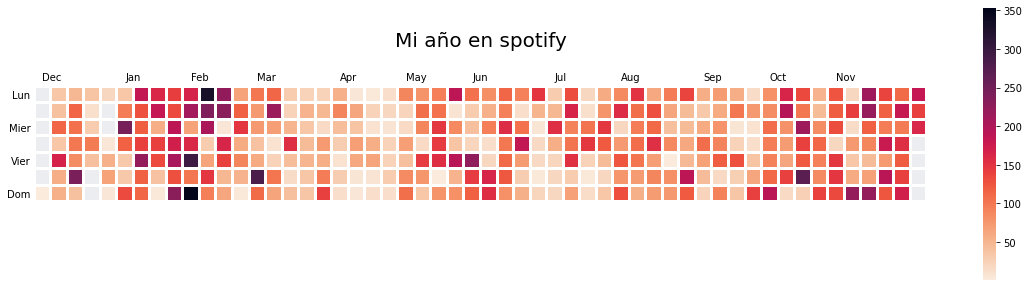

In [ ]:
canciones_dia_mes(read_history())

In [ ]:
canciones_dias(read_history())

In [ ]:
canciones_artistas_unicos(read_history())

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
canciones_mas_escuchadas(read_history())

In [ ]:
top_50 = read_history()
top_50['minutes_played'] = top_50.msPlayed.divide(60000)
top_50.drop('msPlayed', axis=1, inplace=True)
top_50

,endTime,artistName,trackName,minutes_played
0,2019-12-08 20:40:00,Coldplay,See You Soon - Live in Sydney,2.948067
1,2019-12-09 16:45:00,Paul Zinnard,A Good Thing That You Know,3.507783
2,2019-12-09 16:49:00,Los Claxons,Cautiverio,4.134717
3,2019-12-09 16:54:00,Standstill,Hay Que Parar - III. El Corazón De B. Despierta,5.058867
4,2019-12-09 16:55:00,Love of Lesbian,Tercero segunda,1.394433
...,...,...,...,...
32246,2020-12-09 22:48:00,The Rolling Stones,You Can't Always Get What You Want,0.014500
32247,2020-12-09 22:48:00,Daniel Quién,A Estas Horas Del Amor,0.078600
32248,2020-12-09 22:48:00,Lewin,Emotravel,0.015717
32249,2020-12-09 22:48:00,Daniel Quién,Otros Colores,5.863550


In [ ]:
top_50 = top_50.groupby(['trackName'], as_index=False).sum()
top_50 = top_50.sort_values(by='minutes_played', ascending=False).head(51)
top_50.reset_index(inplace = True, drop = True) 
top_50

,trackName,minutes_played
0,Waking Up,1722.157683
1,"Adiós, Que Abras Más Ventanas - Reprise",940.537433
2,My Nights Are More Beautiful Than Your Days,734.886483
3,Las Distancias,719.769183
4,Octubre,677.853600
5,Domingo,640.687383
6,Con los Días Te Vas,615.920067
7,Incendiados,582.572450
8,Estoy Poniendo Todo de Mi Parte,572.738983
9,Estar Sobrio,562.638733
